# Univariate Long Short-Term Memory Neural Network using Keras

In [1]:
#Import the required module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler #sklearn is used to scale the data
from keras.models import Sequential #Keras models are used for LSTM NN
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [2]:
#Window function to split the data and corresponding labels
#in windowed epochs
def windowing (df, win, predl, colidx):
    labels = [] #initialize the lists
    data = []
    for i in range(0, len(df)-predl-win): #stop at beginning of last window minus prediction length
        labels.append(df[colidx][i+win:i+win+predl]) #get the labels sequence of the correct column
        data.append(df[i:i+win]) #get window of data for all columns
    print('Labels shape: ', np.shape(labels)) #print shape for validation
    print('Data shape: ', np.shape(data))
    return np.array(data), np.array(labels) #change format as array and return

In [3]:
#useful constants
#plt.style.use('dark_background') #For sensitive eyes
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 7)
fname =  'Data.csv' #data file name that will be read
fs = 365 #daily sampling frequency = 365 cpy

#--Function parameters--
#-----------------------
train_r = 0.7 #ratio of the data used as training (typ. 70%)
val_r = 0.2 #ratio of data used as validation (typ. 20%)
win = 365 #Window length of data for prediction
predl = 7 #Prediction length
LSTM_units = 50 #Number of unit per LSTM layer (50)
dropoutu = 0.2 #Dropout between two LSTM layer
epochn = 50 #Number of epoch the model will retrain
batchsize = None #Size of the treated data batch

Col_pred = 'LOD' #column name to be predicted

# Data import and treatment
## Read the CSV and keep useful data

For now we will just use the LOD data as predictor and labels.
In this exemple the data has been clipped on the last 5000 points.
As we see, data is complete but raw (goes from negative numbers to positive).

In [4]:
df = pd.read_csv(fname) #Read csv file with ; as separator
df = df[-5000:] #keep last 5000 points (for speed of exec)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LOD,5000.0,0.85878,0.58331,-1.4589,0.489,0.89435,1.276675,2.4889


## Rescale the input data

We use a rescaler function to keep the data between 0 and 1 (important for multi-feature analysis to keep data equal in importance)

In [5]:
col_names = df.columns #store the column names
features = df.values #get the dataframe values

scaler = MinMaxScaler(feature_range=(0,1)).fit(features) #create a scaler between 0 and 1
features = scaler.transform(features) #scale all the columns
scaled_df = pd.DataFrame(features, columns = col_names) #store it in a new dataframe

scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LOD,5000.0,0.587081,0.147756,0.0,0.493414,0.596091,0.692937,1.0


## Split the data between training, validation and test sets

In [6]:
#Create three new dataframes for training, validation and test
#show their shape for validation
n = len(scaled_df)
train_df = scaled_df[:int(n*train_r)]
val_df = scaled_df[int(n*train_r):int(n*(train_r+val_r))]
test_df = scaled_df[int(n*(train_r+val_r)):]

print('\n'.join([
    f'Train shape: {train_df.shape}',
    f'Validation shape: {val_df.shape}',
    f'Test shape: {test_df.shape}',
    f'Total length : {len(train_df)+len(val_df)+len(test_df)}']))

num_features = df.shape[1]

Train shape: (3500, 1)
Validation shape: (1000, 1)
Test shape: (500, 1)
Total length : 5000


## Split the data between window ("win" first points) and labels ("predl" following points)  

In [7]:
train_ds, train_ls = windowing(train_df, win, predl, colidx = Col_pred) #see window function above
val_ds, val_ls = windowing(val_df, win, predl, colidx = Col_pred)  
test_ds, test_ls = windowing(test_df, win, predl, colidx = Col_pred)  

Labels shape:  (3128, 7)
Data shape:  (3128, 365, 1)
Labels shape:  (628, 7)
Data shape:  (628, 365, 1)
Labels shape:  (128, 7)
Data shape:  (128, 365, 1)


# Model Creation and training
## 4 LSTM layers are stacked on each other with a dropout layer in between

In [8]:
model = Sequential()

model.add(LSTM(units = LSTM_units, return_sequences = True, input_shape = (win,num_features)))
model.add(Dropout(dropoutu))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = LSTM_units, return_sequences = True))
model.add(Dropout(dropoutu))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = LSTM_units, return_sequences = True))
model.add(Dropout(dropoutu))

# Adding a fourth LSTM layer and and Dropout layer
model.add(LSTM(units = LSTM_units))
model.add(Dropout(dropoutu))

# Adding the output layer
# For Full connection layer we use dense
# As the output is "predl" dimensions so we use unit=predl
model.add(Dense(units = predl))

#compile and fit the model on epochn epochs, mean squared error is used as loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [9]:
model.summary() #show a summary of our model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 365, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 365, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 365, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 365, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 365, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

## Train the model and show the MSE of the validation test set

In [10]:
history = model.fit(train_ds, train_ls, validation_data = (val_ds,val_ls),
           epochs = epochn, batch_size = batchsize, verbose = 2) 
#we give the train data set and train labels and store the return values in history

Epoch 1/50
98/98 - 56s - loss: 0.0398 - val_loss: 0.0087
Epoch 2/50
98/98 - 49s - loss: 0.0171 - val_loss: 0.0081
Epoch 3/50
98/98 - 46s - loss: 0.0162 - val_loss: 0.0127
Epoch 4/50
98/98 - 47s - loss: 0.0149 - val_loss: 0.0082
Epoch 5/50
98/98 - 47s - loss: 0.0153 - val_loss: 0.0109
Epoch 6/50
98/98 - 49s - loss: 0.0137 - val_loss: 0.0081
Epoch 7/50
98/98 - 49s - loss: 0.0130 - val_loss: 0.0079
Epoch 8/50
98/98 - 65s - loss: 0.0130 - val_loss: 0.0078
Epoch 9/50
98/98 - 54s - loss: 0.0123 - val_loss: 0.0081
Epoch 10/50
98/98 - 51s - loss: 0.0119 - val_loss: 0.0076
Epoch 11/50
98/98 - 53s - loss: 0.0112 - val_loss: 0.0070
Epoch 12/50
98/98 - 51s - loss: 0.0095 - val_loss: 0.0055
Epoch 13/50
98/98 - 48s - loss: 0.0084 - val_loss: 0.0042
Epoch 14/50
98/98 - 52s - loss: 0.0068 - val_loss: 0.0037
Epoch 15/50
98/98 - 58s - loss: 0.0065 - val_loss: 0.0044
Epoch 16/50
98/98 - 51s - loss: 0.0059 - val_loss: 0.0040
Epoch 17/50
98/98 - 52s - loss: 0.0056 - val_loss: 0.0034
Epoch 18/50
98/98 - 50s

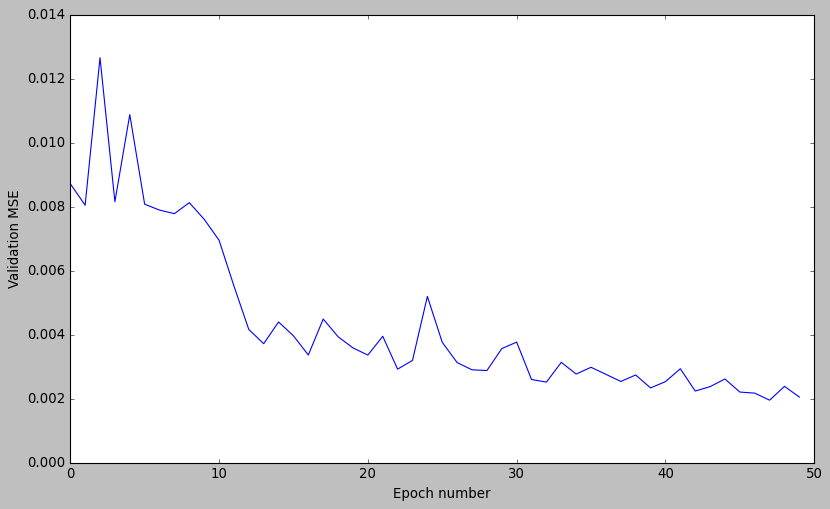

In [11]:
# plot metrics
plt.plot(history.history['val_loss']) #plot the validation loss (MSE)
plt.xlabel('Epoch number')
plt.ylabel('Validation MSE')
plt.show()

Validation MSE goes down as epochs run. This needs to be fine tuned accordingly

# Model output
## RMSE on validation and test sets

In [12]:
scaled_test = model.predict(test_ds) #predict the test set data
scaled_val = model.predict(val_ds) #predict the validation set data

#Calculate RMSE scores
rmse=np.sqrt(np.mean(((scaled_test-test_ls)**2), axis = 0)) #compute the RMSE for each prediction day
print('Test rmse: ', rmse)
rmse=np.sqrt(np.mean(((scaled_val-val_ls)**2), axis = 0))
print('Validation rmse: ', rmse)

Test rmse:  [0.04810084 0.05713427 0.06323808 0.07167118 0.07438839 0.08184645
 0.0866116 ]
Validation rmse:  [0.03261478 0.03757503 0.04193352 0.04582723 0.04944756 0.05192591
 0.05430041]


As expected, the RMSE goes higher with the prediction day (closer prediction to data is better than further away).<br>
Test and validation RMSE are quite similar showing a not overfitted model.<br>
This value is computed on scaled data (between 0 and 1)!

## Prediction of the last data points and plot

In [13]:
last_win = scaled_df[-(win+predl):-predl].values.reshape(1,-1,num_features) #last data window minus 
#predl is extracted
scaled_pred = scaled_df[-predl:].copy() #create new dataframe
scaled_pred.loc[:, Col_pred] = model.predict(last_win).T #model prediction for last window

pred = scaler.inverse_transform(scaled_pred) #Rescale the data to original size
pred = pred[:,0]
pred

array([-0.9801004 , -0.78223205, -0.5883366 , -0.40123054, -0.38162968,
       -0.36022803, -0.46499857], dtype=float32)

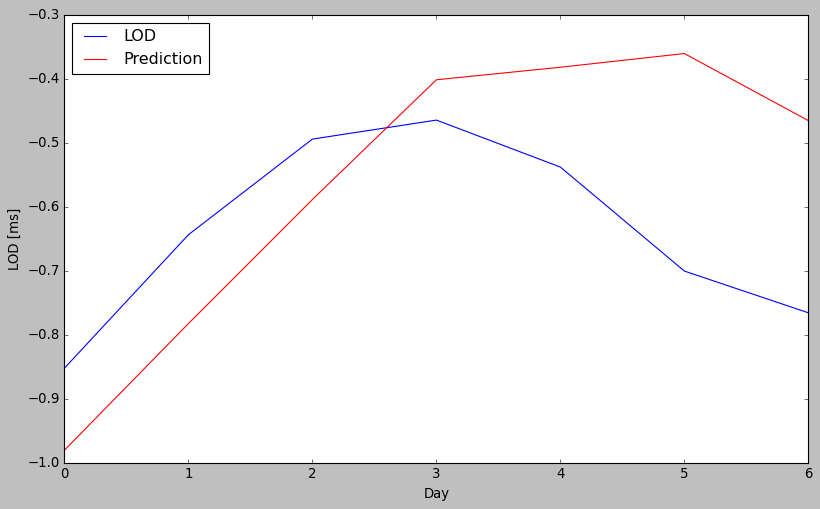

In [14]:
#plot prediction and compare with actual data
fig,ax = plt.subplots()
plt.plot(df.LOD[-predl:].values,'-b', label = 'LOD')
plt.plot(pred,'-r', label = 'Prediction')
ax.set_xlabel ('Day')
ax.set_ylabel ('LOD [ms]')
ax.legend(loc = 0);

## Let's stack all the predictions lengths one after another and plot

In [15]:
lg_pred = np.flip(scaled_test[::-predl][:],0).reshape(-1) #We keep the complete prediction in every predl window
#starting from the end and reshape in one vector
lg_scaled_pred = scaled_df[-len(lg_pred):].copy()
lg_scaled_pred.loc[:, Col_pred] = lg_pred #store it in dataframe with remaining data

lg_pred = scaler.inverse_transform(lg_scaled_pred) #revert to original size
lg_pred = lg_pred[:,0]

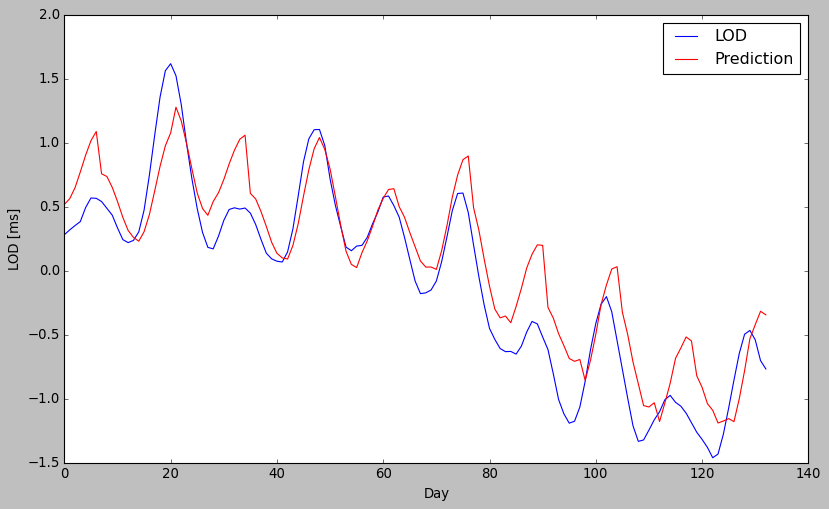

In [16]:
#plot the merged prediction and compare with actual data
fig,ax = plt.subplots()
plt.plot(range(0,len(lg_pred)),df.LOD[-len(lg_pred):].values,'-b', label = 'LOD')
plt.plot(range(0, len(lg_pred)),lg_pred,'-r', label = 'Prediction')
ax.set_xlabel ('Day')
ax.set_ylabel ('LOD [ms]')
ax.legend(loc = 0);

## Now let's just plot the first prediciton day of each epoch and plot it

In [17]:
lg_pred = scaled_test[:,1] #we keep the first predicted value in every epoch
lg_scaled_pred = scaled_df[-len(lg_pred):].copy()
lg_scaled_pred.loc[:, Col_pred] = lg_pred #store it in a dataframe

lg_pred = scaler.inverse_transform(lg_scaled_pred) #rescale it back to original size
lg_pred = lg_pred[:,0]

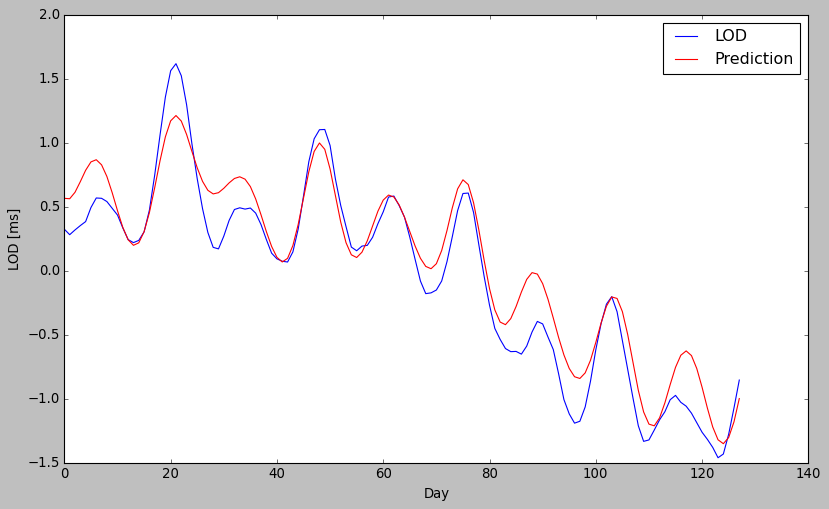

In [18]:
#plot the merged first day prediction and compare with actual data
fig,ax = plt.subplots()
plt.plot(range(0,len(lg_pred)),df.LOD[-len(lg_pred)-predl+1:-predl+1].values,'-b', label = 'LOD')
plt.plot(range(0,len(lg_pred)),lg_pred,'-r', label = 'Prediction')
ax.set_xlabel ('Day')
ax.set_ylabel ('LOD [ms]')
ax.legend(loc = 0);

This is just a first try with an un-tuned model.

Many things can be done to optimize it now:
- Fine tune the model to increase accuracy (epoch number, window size, dropout value, structure of the model)
- Add other predicting values and create multivariate model
- Check the influence of the amount of data used to train the model
- Prepare the input data with filtering
